In [1]:
# Step 0: load the checkpoints (autoencoder, diffusion, and classifier models)
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from lsdm.models.diffusion.ddim import DDIMSampler
from omegaconf import OmegaConf
from lsdm.util import instantiate_from_config
import albumentations
from torchvision import transforms
from lsdm.data.general import DatasetWithClassifierAPIValidation
from lsdm.data.lidc import LIDCNoduleMalignancyClassifierBalancedValidation
from torch.utils.data import DataLoader

"""
Parameters:
"""
# TODO: create meta config file.
device = "cuda:0"
key_feature = "others"  # for new csv files, choose "others"
lsdm_config = "configs/latent-diffusion/lsdm-LIDC-IDRI.yaml"
classifier_config = "configs/classifier/classifier-malignancy.yaml"
classifier_ckpt = "/home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/classifier_mali/epoch119.ckpt"

def load_model_from_config(config, ckpt, device=device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=torch.device("cpu"))#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(torch.device(device))  # load on cuda:1
    model.eval()
    return model

def get_lsdm_model():
    config = OmegaConf.load(lsdm_config)  
    model = load_model_from_config(config, config.model.params.unet_config.params.ckpt_path)
    return model

# load LSDM model (autoencoder+diffusion):
lsdm_model = get_lsdm_model()
# load the sampler with classifier model:
sampler = DDIMSampler(lsdm_model,
                      classifier_guidance=key_feature,
                      classifier_config=classifier_config,
                      classifier_ckpt=classifier_ckpt,)

Loading model from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/lsdm_kl_128x128x3_512resolution/epoch122.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 375.88 M params.
Keeping EMAs of 690.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 128, 128) = 49152 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/autoencoder_kl_128x128x3_512resolution/epoch19.ckpt
Training LatentDiffusion as an unconditional model.
[LSDM classifier] Loading model from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/classifier_mali/epoch119.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 306.78 M params.
Keeping EMAs of 552.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 128, 128) = 49152 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/zuxin

forming training dataset label list...
training dataset label list formed.
dict_keys(['c_spade', 'mask', 'position', 'crop_size_half'])
['/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-1002-95.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0936-76.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0940-263.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0985-271.jpg']


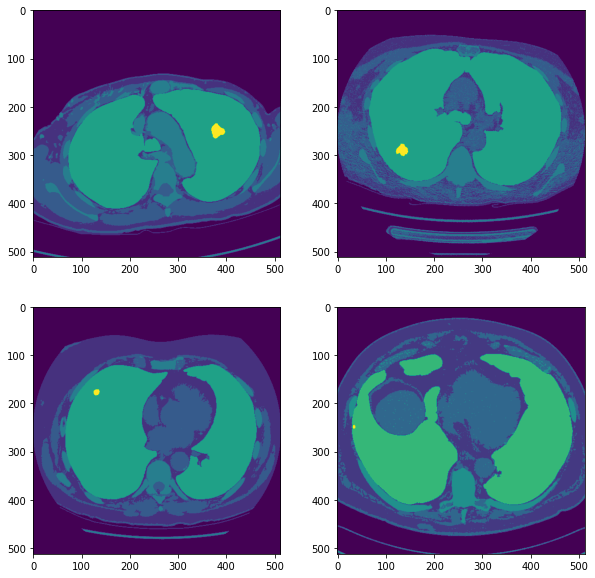

In [4]:
"""
Parameters:
"""
bs = 4

dataset = LIDCNoduleMalignancyClassifierBalancedValidation(nodule_crop_size=64, 
                                                           training_set=False, 
                                                           maxpooling_pixels=4, 
                                                           masked_guidance=True,
                                                           return_original_label=True,
                                                           )
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
# randomly sample a batch using PyTorch DataLoader and transfer the conditionings into a dict:
for i, batch in enumerate(dataloader):
    c_dict = {}
    c_dict["c_spade"] = [batch["label"].to("cuda")]
    c_dict["mask"] = batch["mask"]
    c_dict["position"] = batch["position"]
    c_dict["crop_size_half"] = batch["crop_size_half"]
    break
# show all the keys of the conditionings:
print(c_dict.keys())
# show all the file names picked as the current batch:
print(batch["filename"])

fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs // 2,2,i+1)
    ax.imshow(batch["original_label"][i,:,:])

DDIM Sampler:   0%|          | 0/20 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 128, 128), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


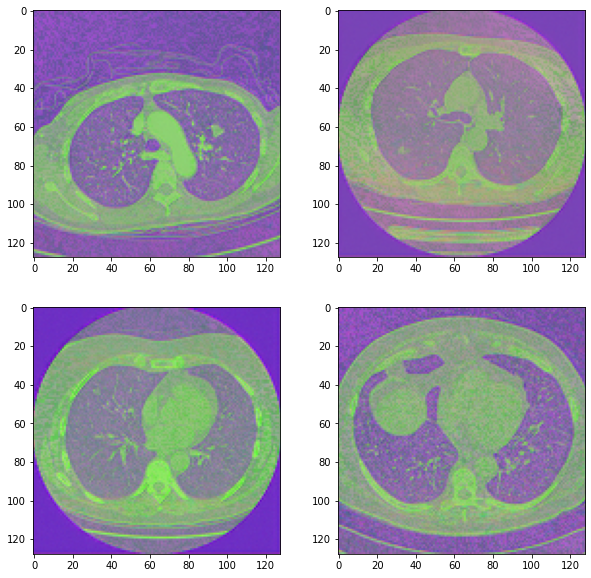

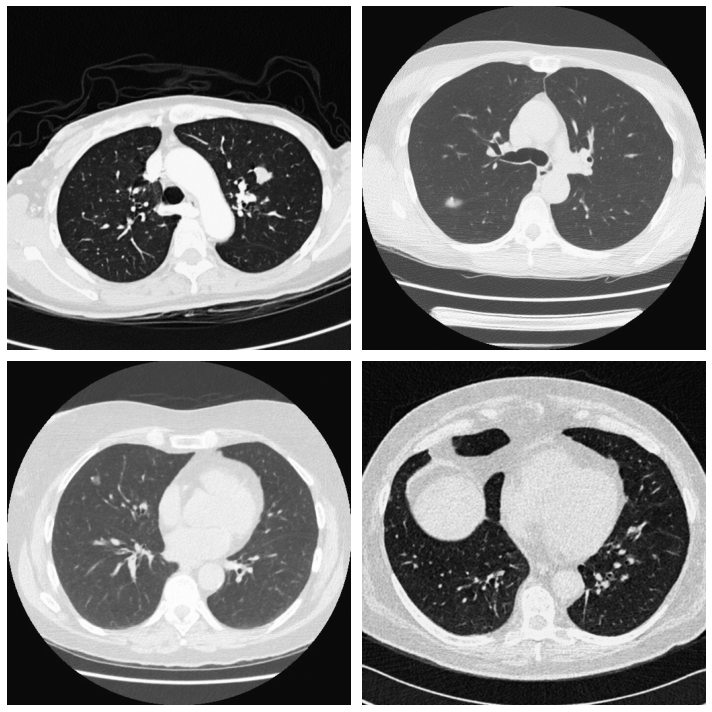

In [5]:
"""
Parameters:
"""
sampling_steps = 20
class_label = 0  # {0,1}
guidance_scale = 1.

# generate latent:
samples_ddim, intermediates = sampler.sample_classifier_guidance(S=sampling_steps,
                                                                 conditioning=c_dict,
                                                                 class_label=class_label,
                                                                 batch_size=bs,
                                                                 shape=[3, 128, 128],
                                                                 verbose=False,
                                                                 unconditional_guidance_scale=3.0,
                                                                 eta=1.0,
                                                                 classifier_guidance_scale=guidance_scale,
                                                                 )
# normalize:
latent = (samples_ddim - torch.min(samples_ddim)) / (torch.max(samples_ddim) - torch.min(samples_ddim))
latent = torch.permute(latent, (0,2,3,1)).cpu().numpy()
latent = (latent * 255).astype(np.uint8)
fig1 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax1 = fig1.add_subplot(bs // 2,2,i+1)
    ax1.imshow(latent[i,:,:,:])

# generated images:
lsdm_model.eval()
x_samples_ddim = lsdm_model.decode_first_stage(samples_ddim)
generated = (x_samples_ddim - torch.min(x_samples_ddim)) / (torch.max(x_samples_ddim) - torch.min(x_samples_ddim))
generated = torch.permute(generated, (0,2,3,1)).cpu().numpy()
fig2 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax2 = fig2.add_subplot(bs//2,2,i+1)
    ax2.imshow(generated[i,:,:,:], cmap="gray")
    ax2.axis("off")
    plt.tight_layout()

In [6]:
# manipulation functions
def remove_nodule(s_map):
    # Create segmentation map without nodule
    segment_wonod = np.zeros((s_map.shape[0], s_map.shape[0]), np.uint8)
    segment_wonod[s_map == 0] = 0
    segment_wonod[s_map == 1] = 1
    segment_wonod[s_map == 2] = 2
    segment_wonod[s_map == 3] = 3
    segment_wonod[s_map == 4] = 4
    segment_wonod[s_map == 5] = 4
    segment_wonod[s_map == 6] = 4
    segment_wonod[s_map == 7] = 4

    return segment_wonod, s_map

def manipulation_expand(tuple_, map_, size_, malignancy_=True):
    map2_ = map_.copy()
    map3_ = map_.copy()
    nodule_ = np.zeros((map_.shape[0], map_.shape[0]), np.uint8)
    if malignancy_:
        malig_ = 7
    else:
        malig_ = 5
    nodule_[tuple_] = malig_

    img_ = Image.fromarray(nodule_)
    img_ = img_.resize((size_, size_))
    temp_ = np.array(img_)
    x = np.where(temp_ == malig_)  # print(map_.max())
    # Sometimes it occurs that the image is reduced in size too much. So much, that the nodule disappears. In that case,
    # increase the size again until the nodule is visible again
    while np.size(x) == 0:
        size_ = size_ * 2
        img_ = Image.fromarray(nodule_)
        img_ = img_.resize((size_, size_))
        temp_ = np.array(img_)
        x = np.where(temp_ == malig_)
    left_ = int(x[1].mean() - tuple_[1].mean())
    bottom_ = int(x[0].mean() - tuple_[0].mean())
    img_ = img_.crop((left_, bottom_, left_ + 512, bottom_ + 512))
    temp_ = np.array(img_)

    map2_[temp_ != 0] = malig_
    map2_[map3_ == 0] = 0
    map2_[map3_ == 1] = 1
    map2_[map3_ == 2] = 2
    map2_[map3_ == 3] = 3
    return map2_

def manipulation_move(tuple_, map_, malignancy_=True, hor=-300, ver=100):
    map2_ = map_.copy()
    map3_ = map_.copy()
    nodule_ = np.zeros((map_.shape[0], map_.shape[0]), np.uint8)
    if malignancy_:
        malig_ = 7
    else:
        malig_ = 5
    nodule_[tuple_] = malig_

    # adjust nodule map to put it at a different position
    if hor != 0:
        if hor > 0:  # means moving nodule to the right.
            nodule_ = np.c_[np.zeros((np.shape(map_)[0], np.abs(hor))), nodule_]
            nodule_ = Image.fromarray(nodule_)
            nodule_ = nodule_.crop((0, 0, map_.shape[0], map_.shape[1]))
        else:
            nodule_ = np.c_[nodule_, np.zeros((np.shape(map_)[0], np.abs(hor)))]
            nodule_ = Image.fromarray(nodule_)
            nodule_ = nodule_.crop((np.abs(hor), 0, map_.shape[0] + np.abs(hor), map_.shape[1]))
        nodule_ = np.array(nodule_)
    if ver != 0:
        if ver < 0:  # means moving the nodule down
            nodule_ = np.concatenate((np.zeros((np.abs(ver), np.shape(map_)[1])), nodule_), axis=0)
            nodule_ = Image.fromarray(nodule_)
            nodule_ = nodule_.crop((0, 0, map_.shape[0], map_.shape[1]))
        else:
            nodule_ = np.concatenate((nodule_, np.zeros((np.abs(ver), np.shape(map_)[1]))), axis=0)
            nodule_ = Image.fromarray(nodule_)
            nodule_ = nodule_.crop((0, np.abs(ver), map_.shape[0], map_.shape[1] + np.abs(ver)))
        nodule_ = np.array(nodule_)
        # need to add the same as above, but then for the vertical direction

    map2_[nodule_ != 0] = malig_
    map2_[map3_ == 0] = 0
    map2_[map3_ == 1] = 1
    map2_[map3_ == 2] = 2
    map2_[map3_ == 3] = 3

    return map2_

def expand_nodule_batch(label_tensor_batch, expand_size=512):
    label_batch = np.array(label_tensor_batch)
    expanded_label_batch = np.zeros(label_batch.shape)
    for (i, label) in enumerate(label_batch):
        if label.max() < 5:
            expanded_label_batch[i] = label
            continue
        else:
            index_nodule = np.where(label == label.max())
            label_wonod, _ = remove_nodule(label)
            label_expand = manipulation_expand(index_nodule, label_wonod, size_=expand_size, malignancy_=True)
        expanded_label_batch[i] = label_expand
    return expanded_label_batch

def move_nodule_batch(label_tensor_batch, hor=0, ver=0):
    label_batch = np.array(label_tensor_batch)
    moved_label_batch = np.zeros(label_batch.shape)
    for (i, label) in enumerate(label_batch):
        if label.max() < 5:
            moved_label_batch[i] = label
            continue
        else:
            index_nodule = np.where(label == label.max())
            label_wonod, _ = remove_nodule(label)
            label_move = manipulation_move(index_nodule, label_wonod, malignancy_=True, hor=hor, ver=ver)
        moved_label_batch[i] = label_move
    return moved_label_batch

def preprocess_segmentation(data, nc=8):
    label_map = torch.LongTensor(data).unsqueeze(0)
    _, h, w = label_map.shape
    input_label = torch.FloatTensor(nc, h, w).zero_()
    input_semantics = input_label.scatter_(0, label_map, 1.0)
    return input_semantics

def preprocess_segmentation_batch(data, nc=8):
    batch = torch.FloatTensor(data.shape[0],nc,data.shape[1],data.shape[2])
    for (i,img) in enumerate(data):
        batch[i] = preprocess_segmentation(img,nc=nc)
    return batch

maxpooling_pixels = 4
pooling_size = np.int32(maxpooling_pixels*2 + 1)
max_pool = torch.nn.MaxPool2d(pooling_size, stride=1, padding=maxpooling_pixels)  # pooling size: 9

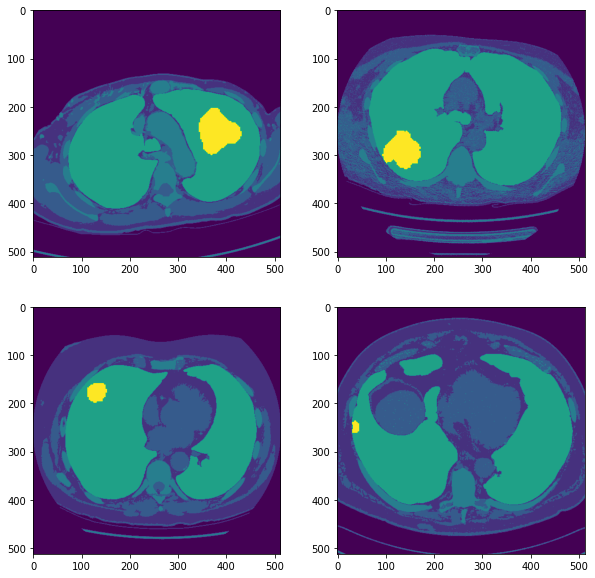

In [7]:
# manipulated labels
"""
Parameters:
"""
resize_factor = 3

expand_size = np.int32(resize_factor * 512)
label_post = expand_nodule_batch(batch["original_label"], expand_size=expand_size)
label_post_preprocessed = preprocess_segmentation_batch(label_post)
label_diffuse = np.array(max_pool(torch.Tensor(label_post).unsqueeze(0))).astype(np.uint8)
mask = np.zeros(label_post.shape)
mask[np.where(label_diffuse[0] >= 5)] = 1
mask = torch.Tensor(mask)
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs // 2,2,i+1)
    ax.imshow(label_post[i,:,:])

DDIM Sampler:   0%|          | 0/20 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 128, 128), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


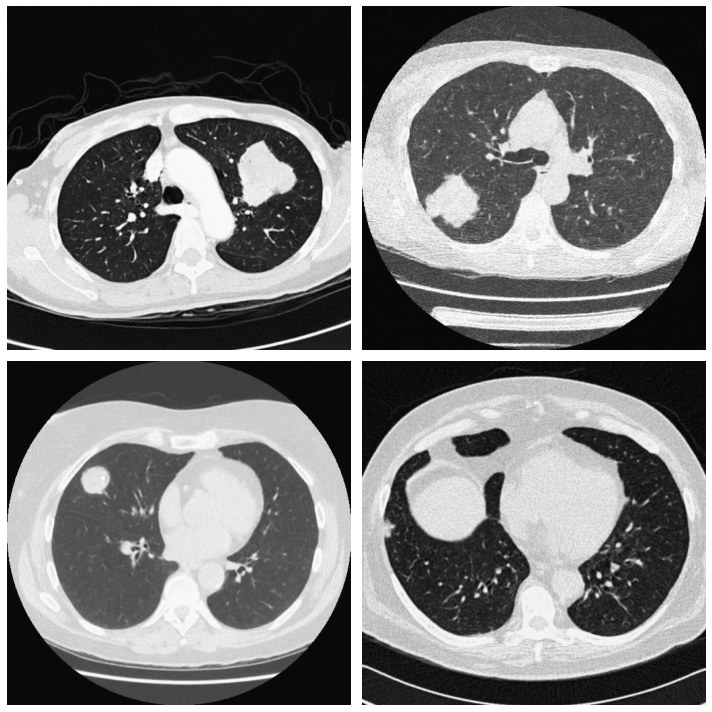

In [9]:
"""
Parameters:
"""
sampling_steps = 20
class_label = 0  # {0,1}
guidance_scale = 1.

c_dict["c_spade"] = [label_post_preprocessed.to("cuda")]
c_dict["mask"] = mask
samples_ddim, intermediates = sampler.sample_classifier_guidance(S=sampling_steps,
                                                                 conditioning=c_dict,
                                                                 class_label=class_label,  # 0: benign
                                                                 batch_size=bs,
                                                                 shape=[3, 128, 128],
                                                                 verbose=False,
                                                                 # alter this parameter to change the guidance scale:
                                                                 classifier_guidance_scale=guidance_scale,
                                                                 )
# normalize:
latent = (samples_ddim - torch.min(samples_ddim)) / (torch.max(samples_ddim) - torch.min(samples_ddim))
latent = torch.permute(latent, (0,2,3,1)).cpu().numpy()
latent = (latent * 255).astype(np.uint8)

lsdm_model.eval()
x_samples_ddim = lsdm_model.decode_first_stage(samples_ddim)
generated = (x_samples_ddim - torch.min(x_samples_ddim)) / (torch.max(x_samples_ddim) - torch.min(x_samples_ddim))
generated = torch.permute(generated, (0,2,3,1)).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs//2,2,i+1)
    ax.imshow(generated[i,:,:,:], cmap="gray")
    ax.axis("off")
    plt.tight_layout()

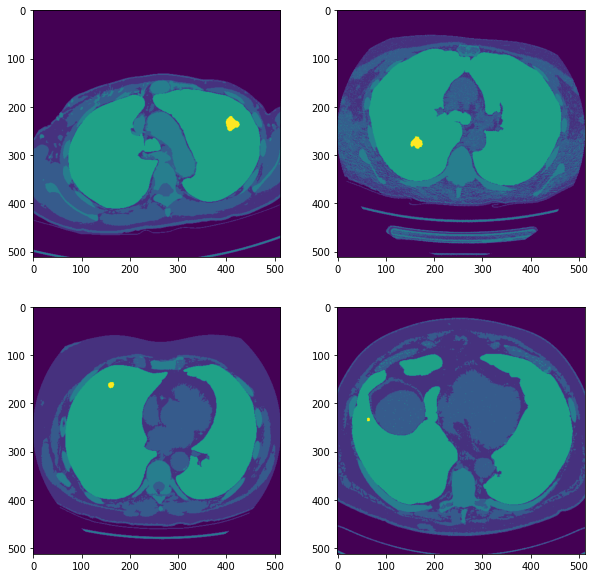

In [10]:
# manipulated labels
"""
Parameters:
"""
horizontal = 30
vertical = 15

label_post = move_nodule_batch(batch["original_label"], hor=horizontal, ver=vertical)
label_post_preprocessed = preprocess_segmentation_batch(label_post)
label_diffuse = np.array(max_pool(torch.Tensor(label_post).unsqueeze(0))).astype(np.uint8)
mask = np.zeros(label_post.shape)
mask[np.where(label_diffuse[0] >= 5)] = 1
mask = torch.Tensor(mask)
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs // 2,2,i+1)
    ax.imshow(label_post[i,:,:])

DDIM Sampler:   0%|          | 0/20 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 128, 128), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


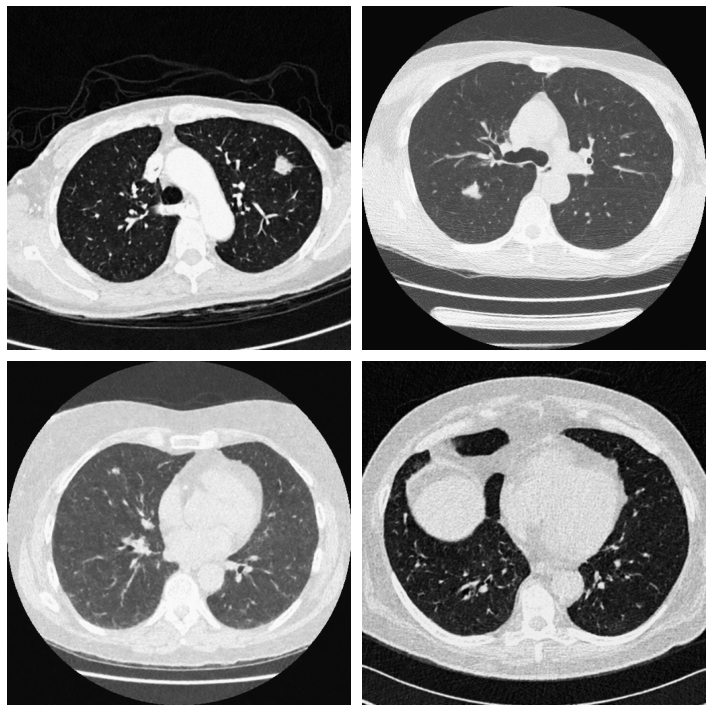

In [11]:
"""
Parameters:
"""
sampling_steps = 20
class_label = 0  # {0,1}
guidance_scale = 1.

c_dict["c_spade"] = [label_post_preprocessed.to("cuda")]
c_dict["mask"] = mask
samples_ddim, intermediates = sampler.sample_classifier_guidance(S=sampling_steps,
                                                                 conditioning=c_dict,
                                                                 class_label=class_label,  # 0: benign
                                                                 batch_size=bs,
                                                                 shape=[3, 128, 128],
                                                                 verbose=False,
                                                                 # alter this parameter to change the guidance scale:
                                                                 classifier_guidance_scale=guidance_scale,
                                                                 )
# normalize:
latent = (samples_ddim - torch.min(samples_ddim)) / (torch.max(samples_ddim) - torch.min(samples_ddim))
latent = torch.permute(latent, (0,2,3,1)).cpu().numpy()
latent = (latent * 255).astype(np.uint8)

lsdm_model.eval()
x_samples_ddim = lsdm_model.decode_first_stage(samples_ddim)
generated = (x_samples_ddim - torch.min(x_samples_ddim)) / (torch.max(x_samples_ddim) - torch.min(x_samples_ddim))
generated = torch.permute(generated, (0,2,3,1)).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs//2,2,i+1)
    ax.imshow(generated[i,:,:,:], cmap="gray")
    ax.axis("off")
    plt.tight_layout()